In [1]:
import pandas as pd
import numpy as np

In [2]:
import pandas as pd
from datetime import datetime
import boto3
from botocore.exceptions import ClientError
from io import StringIO
import s3fs
from fastparquet import ParquetFile
from cleodata.utils.secrets import get_secret
from cleodata.sources.sync.sync import SyncDataSource
boto3.setup_default_session(profile_name='DataScientist-878877078763')
redshift_source = SyncDataSource("data_exploration", use_redshift=True, redshift_cluster="cleo-production-redshift", redshift_db="cleo")

Attempting to uninstrument while already uninstrumented


2024-05-22 17:36:57 [debug    ] fetching credentials          
2024-05-22 17:36:58 [info     ] Credentials acquired          
2024-05-22 17:36:58 [info     ] Built connection pool         


In [3]:
def read_from_s3(path):
    """Read parquet files and combine them into a single dataframe"""
    fs = s3fs.core.S3FileSystem()
    all_paths_from_s3 = fs.glob(path=f"{path}*.parquet")

    if len(all_paths_from_s3) > 0:
        s3 = s3fs.S3FileSystem()
        fp_obj = ParquetFile(
            all_paths_from_s3, open_with=s3.open
        )  # use s3fs as the filesystem
        data = fp_obj.to_pandas()
        return data
    elif len(all_paths_from_s3)==1:
        return pd.read_parquet(all_paths_from_s3[0])
    else:
        print(f"Nothing found")
        print(f"paths from a{all_paths_from_s3}")
    
def read_csv_s3(bucket, key):
    try:
        s3 = boto3.client('s3')
        obj = s3.get_object(Bucket=bucket, Key=key)
        df = pd.read_csv(obj['Body'])
        return df
    except ClientError as ex:
        if ex.response['Error']['Code'] == 'NoSuchKey':
            print("Key doesn't match. Please check the key value entered.")


# Create positive and negative data pairs

In [4]:
path_file = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/raw/transactions_2024-05-20_2024-05-20"

In [5]:
#df_data_raw = read_from_s3(path_file)
df_data_raw = pd.read_csv("/Users/claracastellanos/Documents/DATA/MERCHANTS/2024_05_20.csv")
df_data_raw = pd.read_csv("/Users/claracastellanos/Documents/DATA/MERCHANTS/2024_05_20_sample.csv")

In [6]:
df_data_raw.shape[0]

4930071

In [13]:
# df_data = df_data_raw.sample(500000, random_state=1)
# df_data.to_csv("/Users/claracastellanos/Documents/DATA/MERCHANTS/2024_05_20_sample.csv")

In [14]:
df_data_raw['sentence'] = df_data_raw['original_description_plaid'] + ' ' + df_data_raw['payment_channel']+ ' ' + str(df_data_raw['amount'])


In [15]:
# create pairs based on merchant_name_combined
unique_merchants = df_data_raw['merchant_name_combined'].unique()
print(unique_merchants)
print(len(unique_merchants))

['Zelle' "McDonald''s" 'Cash App' ... "Uncle Henry''s Deli"
 'Pizzaroni Bell Gardens' 'Anju House']
385064


In [16]:
df_merchant_volume = df_data['merchant_name_combined'].value_counts().to_frame()
df_merchant_volume

,count
merchant_name_combined,
Cash App,34402
Zelle,17563
Earnin,10807
Apple,10641
Walmart,9856
...,...
Bravia Nail Spa,1
Tabasco Visitor Ce,1
Midtown Convenien Ck Ansas Ci,1


In [17]:
n_tot_trans  = df_data.shape[0]
df_merchant_volume['perc_traffic'] = df_merchant_volume['count']/n_tot_trans
df_merchant_volume.sort_values(by='perc_traffic', ascending=False)
df_merchant_volume['cumulative_traffic'] = df_merchant_volume['perc_traffic'].cumsum()
df_merchant_volume

,count,perc_traffic,cumulative_traffic
merchant_name_combined,,,
Cash App,34402,0.068804,0.068804
Zelle,17563,0.035126,0.103930
Earnin,10807,0.021614,0.125544
Apple,10641,0.021282,0.146826
Walmart,9856,0.019712,0.166538
...,...,...,...
Bravia Nail Spa,1,0.000002,0.999992
Tabasco Visitor Ce,1,0.000002,0.999994
Midtown Convenien Ck Ansas Ci,1,0.000002,0.999996


In [24]:
df_merchant_volume[0:1000]

,count,perc_traffic,cumulative_traffic
merchant_name_combined,,,
Cash App,34402,0.068804,0.068804
Zelle,17563,0.035126,0.103930
Earnin,10807,0.021614,0.125544
Apple,10641,0.021282,0.146826
Walmart,9856,0.019712,0.166538
...,...,...,...
HTeaO,20,0.000040,0.809752
P.F. Chang''s,20,0.000040,0.809792
Ria,20,0.000040,0.809832


(0.0, 4000.0)

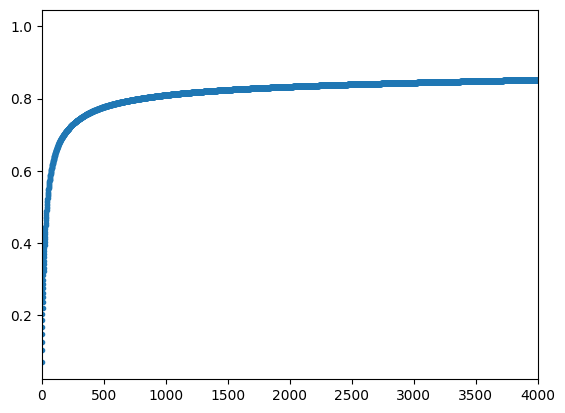

In [32]:
import matplotlib.pyplot as plt
plt.plot(np.arange(df_merchant_volume.shape[0]),df_merchant_volume['cumulative_traffic'],'.')
plt.xlim([0,4000])

In [35]:
df_merchant_volume.reset_index(drop=False,inplace=True)
df_merchant_volume

,merchant_name_combined,count,perc_traffic,cumulative_traffic
0,Cash App,34402,0.068804,0.068804
1,Zelle,17563,0.035126,0.103930
2,Earnin,10807,0.021614,0.125544
3,Apple,10641,0.021282,0.146826
4,Walmart,9856,0.019712,0.166538
...,...,...,...,...
68474,Bravia Nail Spa,1,0.000002,0.999992
68475,Tabasco Visitor Ce,1,0.000002,0.999994
68476,Midtown Convenien Ck Ansas Ci,1,0.000002,0.999996
68477,Tailor Made Barb,1,0.000002,0.999998


In [49]:
merchants_top_2000 = df_merchant_volume['merchant_name_combined'][0:5000].tolist()
print(len(merchants_top_2000))
merchants_top_2000

5000


['Cash App',
 'Zelle',
 'Earnin',
 'Apple',
 'Walmart',
 'Cleo',
 "McDonald''s",
 'Apple Cash',
 'Amazon',
 'MoneyLion',
 'Uber',
 'Varo',
 'Dave',
 'Venmo',
 'Chime',
 'Brigit',
 'Empower',
 'Wells Fargo',
 'Albert',
 'AfterPay',
 'PayPal',
 '7-Eleven',
 'FanDuel Sportsbook',
 'Shell',
 'USAA',
 'Klover App',
 'Dollar General',
 'Zip.co',
 'Uber Eats',
 'DraftKings',
 'Circle K',
 'Starbucks',
 'Target',
 'Sezzle',
 'Lyft',
 'Klarna',
 "Dunkin''",
 'Affirm',
 'Bank of America',
 'Chick-fil-A',
 'BP',
 'QuikTrip',
 '365 Retail Markets',
 'FloatMe',
 'Taco Bell',
 'Capital One',
 'Amazon Prime',
 'Chase Bank',
 'Instacart',
 'DoorDash',
 'Walgreens',
 'Speedway',
 'Dollar Tree',
 "Wendy''s",
 'Chevron',
 'Kroger',
 'Amazon Prime Video',
 'Wawa',
 'Burger King',
 'Publix',
 'CVS',
 'Netflix',
 'BetMGM',
 'Family Dollar',
 'Sony Playstation',
 'T-Mobile',
 'Sonic Drive-In',
 'Chumba Casino',
 'Paypal Pay in 4',
 'OnlyFans',
 'Sheetz',
 'ExxonMobil',
 'DailyPay',
 'Sunoco',
 'Truist Financ

In [48]:
500/60

8.333333333333334

In [50]:
#This step needs to be parallelized
n_pairs = 30
df_all = pd.DataFrame()
for merchant in merchants_top_2000:
  df_s1 = df_data_raw[df_data_raw['merchant_name_combined']==merchant][['transaction_id','sentence','merchant_name_combined']]
  df_s2 = df_data_raw[df_data_raw['merchant_name_combined']!=merchant][['transaction_id','merchant_name_combined']]
  df_negative = pd.concat([df_s1.sample(min(df_s1.shape[0],2*n_pairs),random_state=1)[['transaction_id','sentence']].reset_index(drop=True), \
                           df_s2.sample(min(df_s1.shape[0],2*n_pairs), random_state=1)[['merchant_name_combined']].reset_index(drop=True)], axis=1 , ignore_index=True)
  df_negative['true_label'] = 0
  df_negative['label'] = 0 + np.abs(np.random.normal(0,0.2,[1,df_negative.shape[0]])[0])
  df_negative.columns = ['transaction_id','sentence','merchant_name_combined','true_label','label']
  df_positive = df_s1.sample(min(df_s1.shape[0],n_pairs), random_state=1)
  df_positive['true_label'] = 1
  df_positive['label'] = 1 - np.abs(np.random.normal(0,0.2,[1,df_positive.shape[0]])[0])
  df_all = pd.concat([df_all, df_negative, df_positive[['transaction_id','sentence','merchant_name_combined','true_label','label']] ], axis=0)
  





In [51]:
df_all.shape

(334631, 5)

In [52]:
df_all.to_csv("/Users/claracastellanos/Documents/DATA/MERCHANTS/2024_05_20_sample_top5K_pairs.csv")

In [53]:
print(f"Finished creating file")

Finished creating file


In [54]:
#write this data to s3

In [56]:
df_all.head(20)

,transaction_id,sentence,merchant_name_combined,true_label,label
0,9861390363,CHECKCARD 0517 CASH APP*MARIO*AD XXXXX91940 CA...,Food Lion,0,0.060653
1,9863465715,Cash App Transfer to Christoph other 0 ...,Zealchurch.co,0,0.014648
2,9869624532,MONEY TRANSFER AUTHORIZED ON 05/18 CASH APP*TA...,Publix,0,0.011352
3,9868732447,MONEY TRANSFER AUTHORIZED ON 05/17 CASH APP*ZI...,RaceTrac,0,0.401207
4,9851739256,Cash app*um daddy*cash san franciscocaus other...,AfterPay,0,0.010773
5,9861987135,Transfer from Cash App other 0 25.00...,MoneyLion,0,0.117875
6,9859650459,3836 CASH APP*SILVESTER F52 San Francisco CA 9...,Dollar Tree,0,0.031189
7,9862651079,MONEY TRANSFER AUTHORIZED ON 05/18 CASH APP*JO...,Albert,0,0.165105
8,9864106688,CASH APP*CRYSTAL WAR SAN FRANCISCO CA256098 05...,Chatur,0,0.450697
9,9861917121,"DEBIT CARD PURCHASE AT CASH APP*MATTHEW R, SAN...",Tree House,0,0.003653


In [ ]:
s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/processed/"